In [1]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR
from datasets import inputs
import seaborn as sns
import pandas as pd
import configs

device = 'cpu'

In [2]:
def format_model_name(key):
    if 'rnn' in key:
        return 'RNN-SF'
    elif key == 'linear':
        return 'Linear'
    elif key == 'mlp':
        return 'MLP with Replay Buffer'
    else:
        raise ValueError("Invalid key.")

In [3]:
def get_sparsity(key):
    p = re.compile('.*sparsity(.+?)\/.*')
    if 'sparsity' in key:
        m = p.match(key)
        return m.group(1)
    else:
        return '0'

def get_sigma(key):
    p = re.compile('.*sigma(.+?)\/.*')
    if 'sigma' in key:
        m = p.match(key)
        return m.group(1)
    else:
        return '0'

In [4]:
hue_order = [
    'Linear',
    'RNN-SF',
    'MLP with Replay Buffer',
    #'RNN with Fixed LR', 'RNN with Dynamic LR',
    ]

# Collect aggregate metrics

In [10]:
# Collect measures of all iterations
root_dir = "/home/chingf/engram/Ching/03_td_discrete_corr/"

init_sparsities = []
sigmas = []
gammas = []
models = []
start_losses = []
time_to_elbows = []
final_losses = []

for sparsity_dir in os.listdir(root_dir):
    if 'sparsity' not in sparsity_dir: continue
    for sigma_dir in os.listdir(f'{root_dir}{sparsity_dir}/'):
        for gamma_dir in os.listdir(f'{root_dir}{sparsity_dir}/{sigma_dir}/'):
            path = f'{root_dir}{sparsity_dir}/{sigma_dir}/{gamma_dir}/'
            
            # Get dataset parameters
            init_sparsity = get_sparsity(path)
            sigma = get_sigma(path)
            gamma = float(gamma_dir)
            
            # Iterate over models
            for model_dir in os.listdir(path):
                try:
                    model = format_model_name(model_dir)
                except:
                    continue
                model_path = f'{path}{model_dir}/'
                    
                # Gather metrics for each model iteration
                for iter_dir in os.listdir(model_path):
                    iter_path = model_path + iter_dir + '/'
                    for file in os.listdir(iter_path):
                        if 'tfevents' not in file: continue
                        tfevents_file = iter_path + '/' + file
                        event_acc = EventAccumulator(tfevents_file)
                        event_acc.Reload()
                        scalar_events = event_acc.Scalars('loss_train')
                        values = np.array([event.value for event in scalar_events])
                        if np.any(np.isnan(values)): continue
                        steps = np.array([event.step for event in scalar_events])
                        central_diffs = values[1:] + values[:-1] - 2*values[:-1]
                        if values[0] > values[-1]: # decreasing
                            val95 = values[0] - abs(values[0] - values[-1])*0.95
                            time_to_95 = np.argwhere(values <= val95)[0][0]
                        else: # increasing
                            val95 = values[-1] - abs(values[0] - values[-1])*0.95
                            time_to_95 = np.argwhere(values >= val95)[0][0]
                            
                        init_sparsities.append(init_sparsity)
                        sigmas.append(sigma)
                        gammas.append(gamma)
                        models.append(model)
                        start_losses.append(values[0])
                        time_to_elbows.append(steps[time_to_95])
                        #time_to_elbows.append(steps[np.argmax(central_diffs)])
                        final_losses.append(values[-1])
                        break

init_sparsities = np.array(init_sparsities)
sigmas = np.array(sigmas)
gammas = np.array(gammas)
models = np.array(models)
start_losses = np.array(start_losses)
time_to_elbows = np.array(time_to_elbows)
final_losses = np.array(final_losses)

In [55]:
# Collect best measures over all iterations
root_dir = "/home/chingf/engram/Ching/03_td_discrete_corr/"

init_sparsities = []
sigmas = []
gammas = []
models = []
start_losses = []
time_to_elbows = []
final_losses = []

for sparsity_dir in os.listdir(root_dir):
    if 'sparsity' not in sparsity_dir: continue
    for sigma_dir in os.listdir(f'{root_dir}{sparsity_dir}/'):
        for gamma_dir in os.listdir(f'{root_dir}{sparsity_dir}/{sigma_dir}/'):
            path = f'{root_dir}{sparsity_dir}/{sigma_dir}/{gamma_dir}/'
            
            # Get dataset parameters
            init_sparsity = get_sparsity(path)
            sigma = get_sigma(path)
            gamma = float(gamma_dir)
            
            # Iterate over models
            for model_dir in os.listdir(path):
                try:
                    model = format_model_name(model_dir)
                except:
                    continue
                model_path = f'{path}{model_dir}/'
                    
                # Gather metrics for each model iteration
                best_val = np.inf
                best_set = [np.nan, np.nan, np.nan]
                for iter_dir in os.listdir(model_path):
                    iter_path = model_path + iter_dir + '/'
                    for file in os.listdir(iter_path):
                        if 'tfevents' not in file: continue
                        tfevents_file = iter_path + '/' + file
                        event_acc = EventAccumulator(tfevents_file)
                        event_acc.Reload()
                        scalar_events = event_acc.Scalars('loss_train')
                        values = np.array([event.value for event in scalar_events])
                        if np.any(np.isnan(values)): continue
                        steps = np.array([event.step for event in scalar_events])
                        central_diffs = values[1:] + values[:-1] - 2*values[:-1]
                        if values[0] > values[-1]: # decreasing
                            val95 = values[0] - abs(values[0] - values[-1])*0.95
                            time_to_95 = np.argwhere(values <= val95)[0][0]
                        else: # increasing
                            val95 = values[-1] - abs(values[0] - values[-1])*0.95
                            time_to_95 = np.argwhere(values >= val95)[0][0]
                        start_loss = values[0]
                        time_to_elbow = steps[time_to_95]
                        final_loss = values[-1]
                        if final_loss < best_val:
                            best_val = final_loss
                            best_set = [start_loss, time_to_elbow, final_loss]
                        break
                init_sparsities.append(init_sparsity)
                sigmas.append(sigma)
                gammas.append(gamma)
                models.append(model)
                start_losses.append(best_set[0])
                time_to_elbows.append(best_set[1])
                #time_to_elbows.append(steps[np.argmax(central_diffs)])
                final_losses.append(best_set[2])

init_sparsities = np.array(init_sparsities)
sigmas = np.array(sigmas)
gammas = np.array(gammas)
models = np.array(models)
start_losses = np.array(start_losses)
time_to_elbows = np.array(time_to_elbows)
final_losses = np.array(final_losses)

# Make barplots

In [12]:
df = pd.DataFrame({
    'Sparsity': init_sparsities,
    'Sigma': sigmas,
    'Gamma': gammas,
    'Model': models,
    'Start Loss': start_losses,
    'Time to Elbow': time_to_elbows/(configs.dt_to_sec*60),
    'Final Loss': final_losses
    })

In [ ]:
from datasets import inputs, sf_inputs_discrete
from sr_model.models.models import AnalyticSR, STDP_SR, Linear, MLP, Hopfield
from run_td_rnn import run as run_rnn

sparsity_p = 0.125
spatial_sigma = 1.5
num_states = input_size = 20*20
num_steps = 2000
dataset = sf_inputs_discrete.Sim2DWalk
feature_maker_kwargs = {
    'feature_dim': num_states, 'feature_type': 'correlated_distributed',
    'feature_vals_p': [1-sparsity_p, sparsity_p],
    'spatial_sigma': spatial_sigma
    }
dataset_config = {
    'num_steps': num_steps, 'feature_maker_kwargs': feature_maker_kwargs,
    'num_states': num_states
    }

net = AnalyticSR(
    num_states=input_size, gamma=0.6,
    ca3_kwargs={
        'use_dynamic_lr':False, 'lr': -0.02046,
        'output_params':{
            'num_iterations':25, 'nonlinearity': 'clamp',
            'nonlinearity_args': [-0.055744, 2.045]
            }
        }
    )
_ = run_rnn(
    'test/', net, dataset, dataset_config,
    gamma=0.6,
    train_net=False, test_over_all=False
    )

> /home/chingf/Code/sr-project/run_td_rnn.py(68)run()
-> _, out = net(dg_inputs, dg_modes, reset=True)
(Pdb) l
 63  	    prev_input = None
 64  	    outputs = []
 65  	
 66  	    # Debuggin
 67  	    import pdb; pdb.set_trace()
 68  ->	    _, out = net(dg_inputs, dg_modes, reset=True)
 69  	    subsample = np.random.choice(dg_inputs.shape[0]-1, 50, replace=False)
 70  	    all_s = dg_inputs[subsample]
 71  	    all_next_s = dg_inputs[subsample+1]
 72  	    test_phi = all_s.squeeze(1)
 73  	
(Pdb) dg_inputs.shape
torch.Size([2000, 1, 400])
(Pdb) dg_modes.shape
torch.Size([2000, 1])
(Pdb) net
AnalyticSR(
  (dg): DG()
  (ca3): CA3(
    (nonlin_clamp): LeakyClamp()
  )
)
(Pdb) n


In [86]:
np.unique(init_sparsities)

array(['0.002', '0.008827586206896554', '0.015655172413793106',
       '0.022482758620689658', '0.02931034482758621',
       '0.03613793103448276', '0.042965517241379314',
       '0.049793103448275866', '0.05662068965517242',
       '0.06344827586206897', '0.07027586206896552',
       '0.07710344827586207', '0.08393103448275863',
       '0.09075862068965518', '0.09758620689655173',
       '0.10441379310344828', '0.11124137931034483',
       '0.11806896551724139', '0.12489655172413794', '0.1317241379310345',
       '0.13855172413793104', '0.1453793103448276', '0.15220689655172415',
       '0.1590344827586207', '0.16586206896551725', '0.1726896551724138',
       '0.17951724137931035', '0.1863448275862069', '0.19317241379310346',
       '0.2'], dtype='<U20')

(0.0, 0.05)

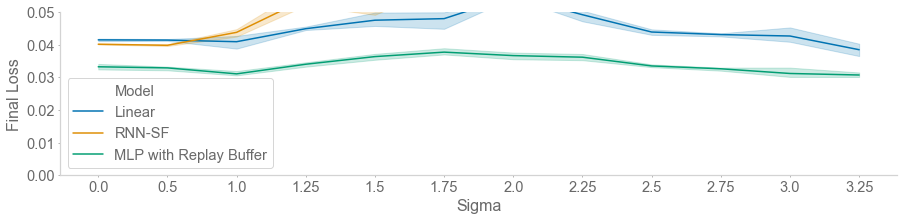

In [27]:
fig, ax = plt.subplots(figsize=(15,3))
sns.lineplot(
    x='Sigma', y='Final Loss', hue='Model',
    ax = ax, data=df[(df['Gamma']==0.6) & (df['Sparsity']=='0.12489655172413794')],
    hue_order=hue_order
    )
ax.set_ylim(0,0.05)

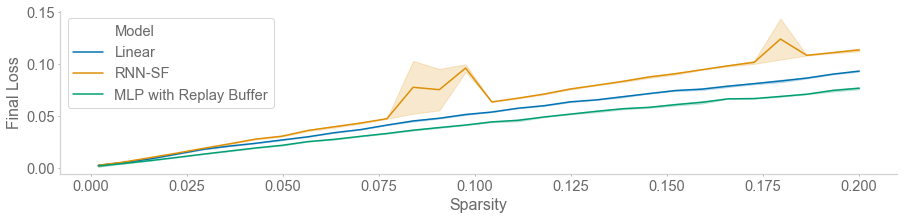

In [73]:
fig, ax = plt.subplots(figsize=(15,3))
sns.lineplot(
    x='Sparsity', y='Final Loss', hue='Model',
    ax = ax, data=df[(df['Gamma']==0.8)& (df['Sigma']<0.75)],
    hue_order=hue_order
    )